In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM ,GRU
from keras.layers import Embedding
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if(len(line) < 1):
            continue
        
        # get image name
        name = line.split('.')[0]
        dataset.append(name)
    return list(set(dataset))

def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename), 'rb')
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [ ]:
doc = load_doc('/content/drive/MyDrive/ImageCaptioning/data/Flickr_TextData/Flickr8k.token.txt')

In [ ]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        #extract file name from image id
        image_id = image_id.split('.')[0]
        # convert desc tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except:
        print(line)

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


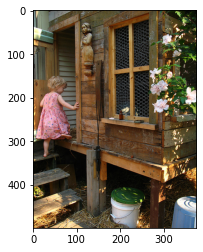

In [ ]:
print(next(iter(descriptions)), descriptions[next(iter(descriptions))])

x = plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/' + next(iter(descriptions)) + '.jpg')
plt.imshow(x)
plt.show()

In [ ]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [ ]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [ ]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [ ]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

In [ ]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [ ]:
train_imgs_addr = '/content/drive/MyDrive/ImageCaptioning/data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_imgs_addr = '/content/drive/MyDrive/ImageCaptioning/data/Flickr_TextData/Flickr_8k.testImages.txt'
dev_imgs_addr = '/content/drive/MyDrive/ImageCaptioning/data/Flickr_TextData/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [ ]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)

In [ ]:
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which appear at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [ ]:
vocab = create_reoccurring_vocab(train_descriptions, word_count_threshold = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action']

In [ ]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # to make sure all the last non digit non alphabet chars are removed
tokenizer = keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 2535


In [ ]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

In [ ]:
# finding the maximum length of questions and answers
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)

print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 18.0
longest sentence:  37
max-len answer for training:  18


In [ ]:
inception = InceptionV3()
extractor = Model(inputs=inception.inputs, outputs=inception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

96124928/96112376 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
def extract_features(description, model, inpute_size = (299,299)):
    directory = '/content/drive/MyDrive/ImageCaptioning/data/Images/'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(description))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        features[name] = feature.reshape(2048)
    return features

In [ ]:
train_features = extract_features(train_descriptions, extractor)
test_features = extract_features(test_descriptions, extractor)
dev_features = extract_features(dev_descriptions, extractor)

In [ ]:
pickle.dump(train_features, open('/content/drive/MyDrive/ImageCaptioning/train_features.pkl', 'wb'))
pickle.dump(test_features, open('/content/drive/MyDrive/ImageCaptioning/test_features.pkl', 'wb'))
pickle.dump(dev_features, open('/content/drive/MyDrive/ImageCaptioning/dev_features.pkl', 'wb'))

In [ ]:
with open('/content/drive/MyDrive/ImageCaptioning/dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)  
with open('/content/drive/MyDrive/ImageCaptioning/train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('/content/drive/MyDrive/ImageCaptioning/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

In [ ]:
batch_size=32
emb_dim=50

In [ ]:
# outputs a batch of captions-pictures
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = tokenizer.texts_to_sequences(desc.split())
                # split one sequence into multiple X, y pairs
                # Loop: selects one word from the caption,
                # consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == batch_size:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
d = next(data_generator(dev_descriptions, dev_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((1920, 2048), (1920, 18), (1920,))

In [ ]:
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        glove_dir = '/content/drive/MyDrive/ImageCaptioning/glove/'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # Keras Embedding layer - all 0
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')
        
    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

In [ ]:
embedding_layer = make_embedding_layer(emb_dim, glove=True)

GloVe loaded!


In [ ]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
from keras.layers import RepeatVector
def make_model(embedding ,dout= 0.2, feature_size= 2048, units= 256):
    
    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe_one_dim = Dense(units, activation='relu')(features) 
    zero_out = Lambda(lambda x: tf.zeros_like(x))(X_fe_one_dim)
    # repeat 1 more time
    X_fe = RepeatVector(max_length)(X_fe_one_dim)
    X_fe = Dropout(dout)(X_fe)
    
    seq = Input(shape=(max_length,))
    X_seq = embedding(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq) # remove mask from the embedding cause concat doesn't support it
    X_seq = Dropout(dout)(X_seq)
    X_seq = Concatenate(name='concat_features_word_embeddings', axis=-1)([X_fe,X_seq])
    
    X_seq = LSTM(units, return_sequences=True)(X_seq,initial_state=[X_fe_one_dim,zero_out]) # passing features as init_state
    X_seq = Dropout(dout + 0.2)(X_seq)
    X_seq = LSTM(units, return_sequences=False)(X_seq)

    outputs = Dense(vocab_size, activation='softmax')(X_seq)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

In [ ]:
model = make_model(embedding_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 18, 50)       126750      ['input_3[0][0]']                
                                                                      

In [ ]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

In [ ]:
history={'loss':[], 'BLEU_val':[]}

In [ ]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteration of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [ ]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)


    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [ ]:
from keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

====


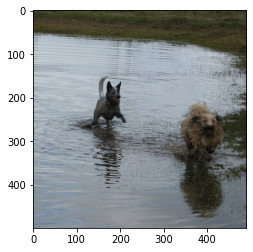

Greedy: railing skeleton pads pads painting followed followed followed followed followed followed followed followed followed followed followed followed


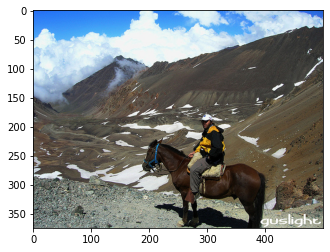

Greedy: heavily followed followed followed followed followed followed followed followed followed followed followed followed followed followed followed followed


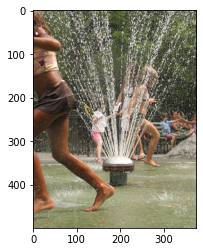

Greedy: clad ropes ropes ropes ropes ropes ropes ropes ropes ropes ropes ropes ropes ropes ropes ropes gray


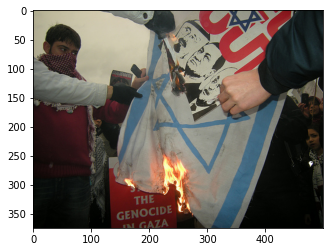

Greedy: covers basket swinging swinging swinging swinging swinging swinging swinging swinging swinging swinging swinging swinging swinging swinging swinging
====


In [ ]:
def test(i=np.random.randint(len(test_features)), j=np.random.randint(len(test_features)),
         k=np.random.randint(len(test_features)), q=np.random.randint(len(test_features)), show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:", generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====')
    
    
test(show_pic=True)    

In [ ]:
steps = len(train_descriptions)//batch_size

In [ ]:
# create the data generator
generator = data_generator(train_descriptions, train_features)

In [ ]:
ep=1

In [ ]:
weight_folder = '/content/drive/MyDrive/ImageCaptioning/IC_glove_50d/LSTM_weight'

In [ ]:
for i in range(ep, 101):
    
    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    
    # save model every 25 epochs
    if i % 25 == 0:
        test() 
        model.save_weights(weight_folder+'/model_' + str(i) + '.h5')
        belus= evaluate_model(model, dev_descriptions, dev_features, K_beams=1)    
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

Epoch : 31 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


187/187 [==============================] - 96s 514ms/step - loss: 2.4549 - lr: 0.0010

Epoch : 32 

187/187 [==============================] - 68s 364ms/step - loss: 2.4363 - lr: 0.0010

Epoch : 33 

187/187 [==============================] - 67s 360ms/step - loss: 2.4234 - lr: 0.0010

Epoch : 34 

187/187 [==============================] - 67s 359ms/step - loss: 2.4098 - lr: 0.0010

Epoch : 35 

187/187 [==============================] - 68s 362ms/step - loss: 2.4016 - lr: 0.0010

Epoch : 36 

187/187 [==============================] - 68s 361ms/step - loss: 2.3923 - lr: 0.0010

Epoch : 37 

187/187 [==============================] - 68s 364ms/step - loss: 2.3841 - lr: 0.0010

Epoch : 38 

187/187 [==============================] - 68s 363ms/step - loss: 2.3725 - lr: 0.0010

Epoch : 39 

187/187 [==============================] - 68s 362ms/step - loss: 2.3624 - lr: 0.0010

Epoch : 40 

187/187 [==============================] - 69s 366ms/step - loss: 2.3463 - lr: 0.0010

Epoch : 41 



In [ ]:
import pickle

with open('/content/drive/MyDrive/ImageCaptioning/LSTM_history_image_caption.pkl','wb') as f:
    pickle.dump(history, f) 

In [43]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

AssertionError: ignored

In [ ]:
# apprently model overfits badly after epoch 100. so im just gonna use the model from 75th epoch
i=75

model.load_weights(weight_folder+'/model_' + str(i) + '.h5')

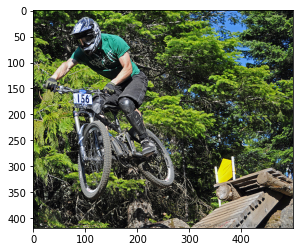

Greedy: a man on a bike jumping off a ramp
Beam K= 3: a man on a bike doing a trick in the air
Beam K= 5: a man on a bike doing a trick in the air
Beam log K= 3: a man on a bike doing a trick in the air
Beam log K= 5: a man on a bike doing a trick in the air


In [ ]:
pic = list(test_features.keys())[189]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

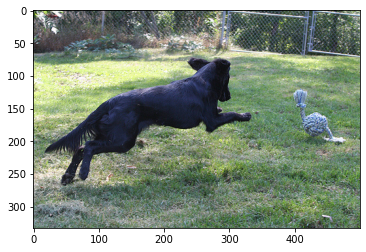

Greedy: a black dog is running through a grassy field
Beam K= 3: a black dog jumps in the air to catch a frisbee
Beam K= 5: a black dog jumps in the air to catch a frisbee
Beam log K= 3: a black dog jumps in the air to catch a frisbee
Beam log K= 5: a black dog jumps in the air to catch a frisbee


In [ ]:
pic = list(test_features.keys())[456]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

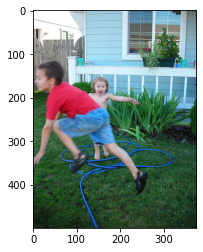

Greedy: a man in a green shirt is walking away from a tree
Beam K= 3: a man lays on a lawn bench
Beam K= 5: a man lays on a sidewalk near a tree
Beam log K= 3: a man lays on the grass near a tree
Beam log K= 5: a man lays on the grass near a tree


In [ ]:
pic = list(test_features.keys())[234]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

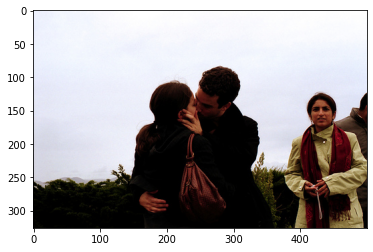

Greedy: a man and a woman are standing on a hill overlooking a city
Beam K= 3: a man and a woman are standing next to a fence in front of a mountain
Beam K= 5: a man and a woman are standing in front of a mountain
Beam log K= 3: a man and a woman are standing on a hill overlooking a city
Beam log K= 5: a man and a woman are standing in front of a mountain


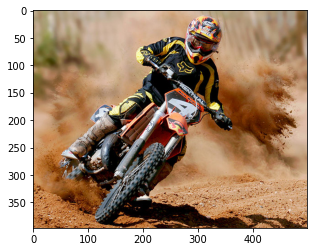

Greedy: a man in a helmet rides a bike through the woods
Beam K= 3: a man in a helmet rides a bike through the woods
Beam K= 5: a man wearing a helmet rides a bike through the woods
Beam log K= 3: a man wearing a helmet rides a bike through the woods
Beam log K= 5: a man wearing a helmet rides a bike through the woods


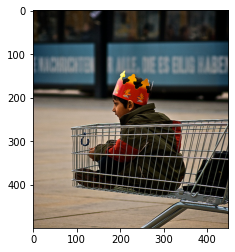

Greedy: a boy pushes a cart on a scooter
Beam K= 3: a little boy pushes a cart on a bike
Beam K= 5: a little boy rides a scooter on a sidewalk
Beam log K= 3: a little boy in a red shirt is riding a scooter on a street
Beam log K= 5: a little boy rides a scooter on a street


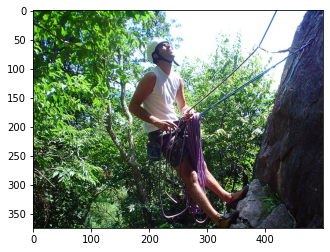

Greedy: a man in a red shirt climbs a rock
Beam K= 3: a man in a red shirt climbs a rock
Beam K= 5: a man in a red shirt climbs a rock
Beam log K= 3: a man in a red shirt climbs a rock
Beam log K= 5: a man in a red shirt climbs a rock


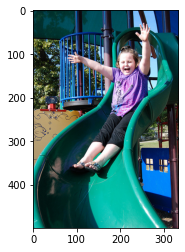

Greedy: a girl slides down a slide
Beam K= 3: a girl slides down a red slide
Beam K= 5: a girl slides down a red slide
Beam log K= 3: a young girl slides down a purple slide
Beam log K= 5: a young girl slides down a purple slide


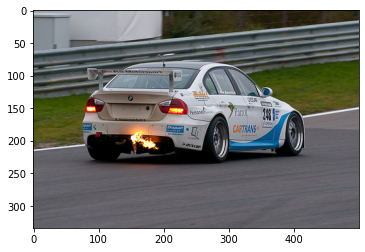

Greedy: a race car driver is <UNK> by the rear of a car
Beam K= 3: a blue race car is driving on a racetrack
Beam K= 5: a blue race car is driving on a racetrack
Beam log K= 3: a blue race car is driving on a racetrack
Beam log K= 5: a blue race car is driving on a racetrack


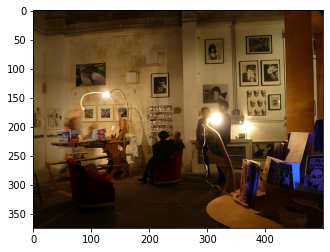

Greedy: a man sits at a bar with a neon <UNK> store
Beam K= 3: two men are standing in front of a bus
Beam K= 5: there are two people in front of a crowded street
Beam log K= 3: two people are sitting in a room with a neon sign
Beam log K= 5: three people are sitting at a table at night


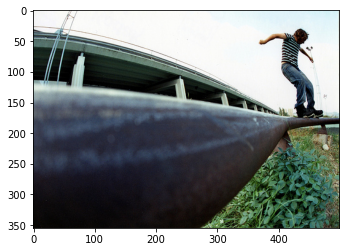

Greedy: a man is doing a trick on a bike
Beam K= 3: a man is doing a trick on a bike
Beam K= 5: a man performs a trick on a bicycle in a skate park
Beam log K= 3: a man is doing a trick on a bicycle in a skate park
Beam log K= 5: a man performs a trick on a bicycle in a skate park


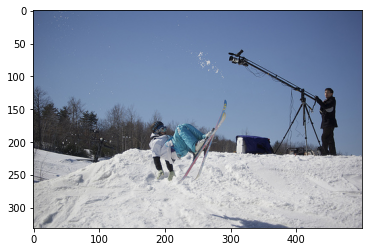

Greedy: a skier is making a jump in the air
Beam K= 3: a skier flies through the air above a snowy hill
Beam K= 5: a skier flies through the air on skis
Beam log K= 3: a skier flies through the air above a snowy hill


In [ ]:
i = 0
while(i < 10):
  pic = list(test_features.keys())[np.random.randint(1,1000)]
  fe = test_features[pic].reshape((1,2048))
  x=plt.imread('/content/drive/MyDrive/ImageCaptioning/data/Images/'+pic+'.jpg')
  plt.imshow(x)
  plt.show()
  print("Greedy:",generate_desc(model, fe, inference=True))
  print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
  print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
  print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
  print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))
  i += 1